
# Topic: Time Series Analysis of Avocado Price in the US from 2015 to 2019


## Goal1: Predict the price of the avocado (Autoregression)
## Goal 2: Classify the trend of the avocado price time series (KNN)

# Data Preparation

## Dataset Description

##### Input Data resource AvocadoPriceTotalUS20152019.csv#####
    The data I used in this project is from Kaggle page 
    (https://www.kaggle.com/alanluo418/avocado-prices-20152019). 
    All the data was obtained from the Hass Avocado Board website in January of 2020.
    The above page refers to an earlier Kaggle page about Avocado price
    (https://www.kaggle.com/neuromusic/avocado-prices).

##### Columns in the input dataset AvocadoPriceTotalUS20152019.csv#####
    Date - The date of the observation
    AveragePrice - The Average Sales Price of Current Year
    Total Volume - Total Bulk and Bags Units
    4046 - Total number of avocados with PLU 4046 sold
    4225 - Total number of avocados with PLU 4225 sold
    4770 - Total number of avocados with PLU 4770 sold
    type - conventional or organic
    year - the current year
    region - the city or region of the observation
    
    -------------------------------------------------------

    TotalVolume = 4046 + 4225 + 4770 + TotalBags
    TotalBags = SmallBags + LargeBags + XLargeBags

##### Output dataset after cleansing and feature creation #####
    From the Kaggle dataset AvocadoPriceTotalUS20152019.csv, I created a dataset for my analysis, 
    which is called AfterCleansingFeatureCreation_AvocadoPriceUSA20152019.csv. 
    
    Following points have been addressed:
    
    1. Identify different naming ways for the region columns. 
    For example,'TotalUS' (before 2016) vs 'Total U.S.'(since 2016). 
    Solution: Unifying the naming ways and create a new columns called Region 
    by removing all the non-letter compoenent in the region name.
    
    2. Identify the regions with different geographic levels, countries, states, cities. 
    Conclude to use city level region data for the analysis for three reasons. 
    First, choosing a level to work with is to avoid multiple counting of the same data. 
    Second, city level data gives more insight about the geographic distribution. 
    Third, the country level data has anomaly in the AveragePrice and Total Volumne columns, 
    while the state-level data is far away from complete.
    
    3. I added columns of the geograhic information of the region based on the information here:
    https://raw.githubusercontent.com/plotly/datasets/master/2014_us_cities.csv
    
    4. I forced the date to be have pandas date format, so it is easiler to be used.
    
    
##### Columns in the output dataset AfterCleansingFeatureCreation_AvocadoPriceUSA20152019.csv#####
    Date - The date of the observation
    AveragePrice - The Average Sales Price of Current Year
    Total Volume - Total Bulk and Bags Units
    4046 - Total number of avocados with PLU 4046 sold
    4225 - Total number of avocados with PLU 4225 sold
    4770 - Total number of avocados with PLU 4770 sold
    Total Bags - 
    Small Bags - 
    Large Bags - 
    XLarge Bags - 
    type - conventional or organic
    year - the current year
    region - original region name with not consistent name
    Month - the current month
    Region - region names after unification
    name - region name in the orginal geo_dataframe
    pop - population of the region
    lat - latitude of the region
    lon - longitude of the region
    
 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
from queue import Queue
import pandas as pd
import json
%matplotlib inline

## Import data

In [71]:
df = pd.read_csv('../Captone/Avocado20152020.csv')
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27323 entries, 0 to 27322
Data columns (total 13 columns):
Date            27323 non-null object
AveragePrice    27323 non-null float64
Total Volume    27323 non-null float64
4046            27323 non-null float64
4225            27323 non-null float64
4770            27323 non-null float64
Total Bags      27323 non-null float64
Small Bags      27323 non-null float64
Large Bags      27323 non-null float64
XLarge Bags     27323 non-null float64
type            27323 non-null object
year            27323 non-null int64
region          27323 non-null object
dtypes: float64(9), int64(1), object(3)
memory usage: 2.7+ MB


## Data Cleansing and Feature Creation

Check if there is null values

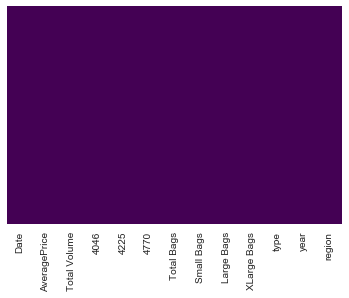

In [73]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')


    It seems that we do not have null data here. But we still need to check carefully.

### Column_Date

Let's force the date to be a pandas datetime columns, so that we can also have monthly, yearly data more easily.

In [74]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,Month
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,1
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,2


### Column_AveragePrice

 This is one of the most interesting data for us in this dataset. 

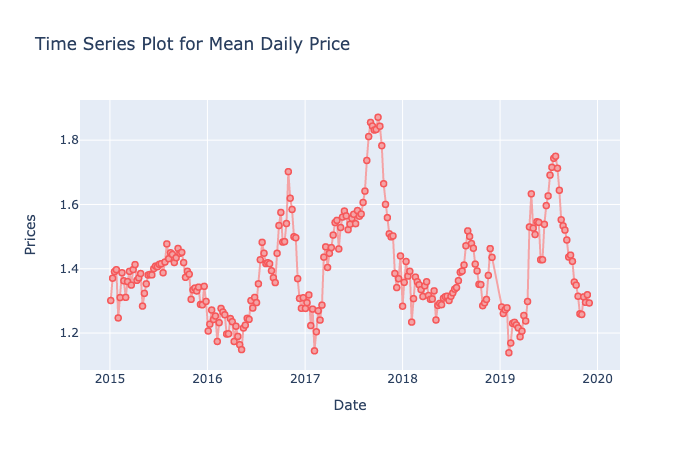

In [77]:
#Let's plot a overall time series for the Average Price.

import plotly
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

groupBy_Overall = df.groupby('Date').mean()

scatter = go.Scatter(x=groupBy_Overall.AveragePrice.index, y=groupBy_Overall.AveragePrice,mode='lines+markers',
                    marker=dict(
                                 color='rgb(248,146,146)',
                                 line=dict(
                                 color='rgb(249,52,52)',
                                 width=1.5)),
                                opacity=0.8)
data = [scatter]
layout = go.Layout(title='Time Series Plot for Mean Daily Price',
                  xaxis={'title':'Date'},yaxis={'title':'Prices'})

fig = go.Figure(data=data, layout=layout)
# iplot(fig)
fig.show("png")


    It seems like that there is a period changes. On top of that, the price in 2017 seems relatively higher.

### Column_Total_Volume

 The Total Volume sold is also an ineresting time series.

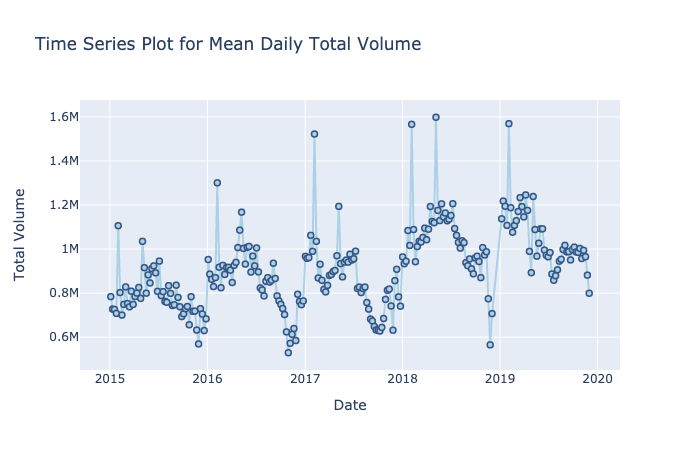

In [78]:
#Let's plot a overall time series for the Average Price.

import plotly
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

groupBy_Overall = df.groupby('Date').mean()

scatter = go.Scatter(x=groupBy_Overall['Total Volume'].index, y=groupBy_Overall['Total Volume'],mode='lines+markers',
                    marker=dict(
                                 color='rgb(158,202,225)',
                                 line=dict(
                                 color='rgb(8,48,107)',
                                 width=1.5)),
                                opacity=0.8)
data = [scatter]
layout = go.Layout(title='Time Series Plot for Mean Daily Total Volume',
                  xaxis={'title':'Date'},yaxis={'title':'Total Volume'})

fig = go.Figure(data=data, layout=layout)
# iplot(fig)
fig.show("png")


    It seems like that there is a period changes. 
    On top of that, the total volumns has seen an overall increase in the past five years.

###  Column_Region

Here I would like to add the geographic information for different regions of the USA. 
We can get the latitude and longitude of the USA region so that we visualzation can be applied on a map.

In [79]:
#Let's first check what kind of regions are there.
df.region.unique()

array(['Albany', 'Atlanta', 'Baltimore/Washington', 'BaltimoreWashington',
       'Boise', 'Boston', 'Buffalo/Rochester', 'BuffaloRochester',
       'California', 'Charlotte', 'Chicago', 'Cincinnati/Dayton',
       'CincinnatiDayton', 'Columbus', 'Dallas/Ft. Worth',
       'DallasFtWorth', 'Denver', 'Detroit', 'Grand Rapids',
       'GrandRapids', 'Great Lakes', 'GreatLakes', 'Harrisburg/Scranton',
       'HarrisburgScranton', 'Hartford/Springfield',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'Las Vegas', 'LasVegas', 'Los Angeles', 'LosAngeles', 'Louisville',
       'Miami/Ft. Lauderdale', 'MiamiFtLauderdale', 'Midsouth',
       'Nashville', 'New Orleans/Mobile', 'New York', 'NewOrleansMobile',
       'NewYork', 'Northeast', 'Northern New England',
       'NorthernNewEngland', 'Orlando', 'Philadelphia', 'Phoenix/Tucson',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'Raleigh/Greensboro', 'RaleighGreensboro', 'Richmond/Norfolk',


    After a glance we can see that there are a few things a want to point out in this data:
    
    1. For one region there are two ways of naming it. 
    For exmaple : 'TotalUS' and 'Total U.S.' 
    And you plot these two dataset, you will find out 'TotalUS' corresponds to the time window before 2016, 
    while 'Total U.S.' are for the data after 2016.
    
    2. Regions are in different geographic levels: 
    Whole country, some regions includig a few states, states and city. 
    So some records of data are the aggregation of the other datas, for example TotalUS.

In [80]:
#For the first point:
#Let's unify the name of the region by removing all the space in the name of the region by using the following function:
def letter_only(mixedstring):
    return ''.join(x for x in mixedstring if x.isalpha())

In [81]:
#Let's create a new colonm for the df.
df['Region'] = df['region'].apply(letter_only)
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,Month,Region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1,Albany
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1,Albany
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1,Albany
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,1,Albany
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,2,Albany


In [82]:
# #Drop out the not unified region label.
df.drop('region',inplace=True,axis=1)

For the second point:
Let's stick to one level of geographic unit, so that we do not count a data multiple times. 
The question is which level to choose: country? States? or City? 
Maybe we can go for the better data or the data gives more valuable insight?


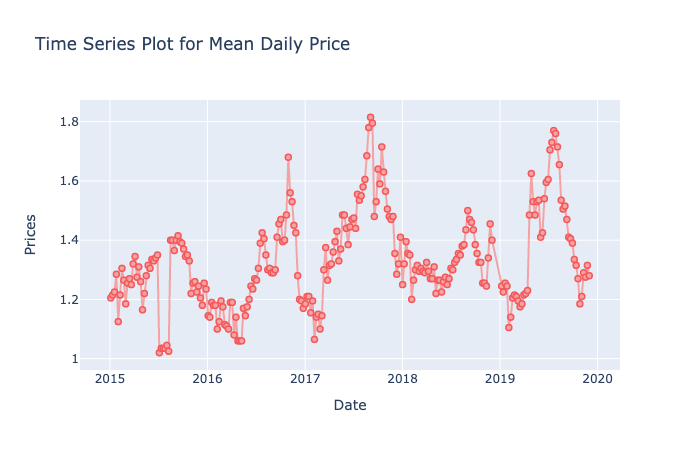

In [83]:
#Let's plot a overall time series for the Average Price for TotalUS.

import plotly
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

groupBy_Overall = df[df.Region=='TotalUS'].groupby('Date').mean()

scatter = go.Scatter(x=groupBy_Overall.AveragePrice.index, y=groupBy_Overall.AveragePrice,mode='lines+markers',
                    marker=dict(
                                 color='rgb(248,146,146)',
                                 line=dict(
                                 color='rgb(249,52,52)',
                                 width=1.5)),
                                opacity=0.8)
data = [scatter]
layout = go.Layout(title='Time Series Plot for Mean Daily Price',
                  xaxis={'title':'Date'},yaxis={'title':'Prices'})

fig = go.Figure(data=data, layout=layout)
# iplot(fig)
fig.show("png")


    Clearly there are some bad data July 2015.

In [51]:
#If we use the city level data.

#Let's delete the already aggregated regions.
df = df[df.Region!='TotalUS']
df = df[df.Region!='Southeast']
df = df[df.Region!='West']
df = df[df.Region!='SouthCentral']
df = df[df.Region!='Northeast']
df = df[df.Region!='GreatLakes']
df = df[df.Region!='Plains']
df = df[df.Region!='Midsouth']
df = df[df.Region!='California']
df = df[df.Region!='NorthernNewEngland']
df = df[df.Region!='SouthCarolina']
df = df[df.Region!='WestTexNewMexico']

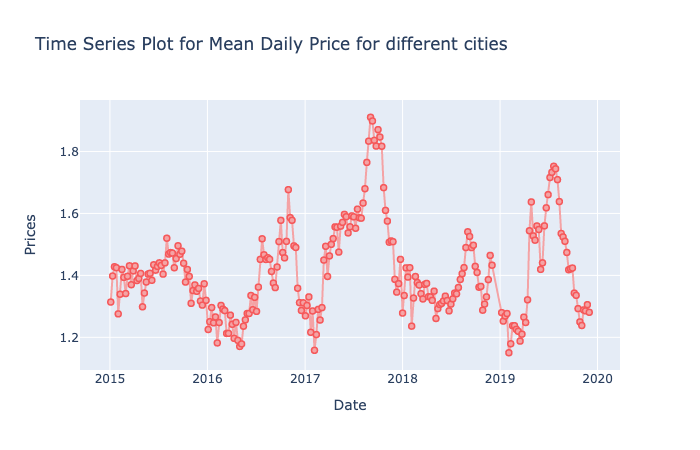

In [69]:
#Let's plot a overall time series for the Mean Daily for All cities.

import plotly
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

groupBy_Overall = df.groupby('Date').mean()

scatter = go.Scatter(x=groupBy_Overall.AveragePrice.index, y=groupBy_Overall.AveragePrice,mode='lines+markers',
                    marker=dict(
                                 color='rgb(248,146,146)',
                                 line=dict(
                                 color='rgb(249,52,52)',
                                 width=1.5)),
                                opacity=0.8)
data = [scatter]
layout = go.Layout(title='Time Series Plot for Mean Daily Price for different cities',
                  xaxis={'title':'Date'},yaxis={'title':'Prices'})

fig = go.Figure(data=data, layout=layout)
# iplot(fig)
fig.show("png")

    Here the data trend is comparable with the TotalUScase but without a anomaly. 
    Actually if you check the Total Volumn time series, you will also find a few anomalies in the TotalUS case. 
    So it is clear we are not going to use that given here we can get a better view with he city break down data
    Besides, this city break down also provides more geographic information I am actually interested.

In [15]:
#I would like to import the geographic information about different regions.

In [53]:

#import a USA geographic dataframe.
df_USgeo = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_us_cities.csv')
df_USgeo.head()

#But the format of the region name is different between this dataframe (df_USgeo) and the avocado price dataframe (df).
#Let's make them the same by removing all the space in the name of the region by using the following function:
# def letter_only(mixedstring):
#     return ''.join(x for x in mixedstring if x.isalpha())

#Let's create a new colonm for the df_USgeo.
df_USgeo['Region'] = df_USgeo['name'].apply(letter_only)
df_USgeo.head()


#Let's save the dataframe
df_USgeo.to_csv('/Users/liujing/Desktop/Coursera/Captone/usaRegionGeoInfo.csv')

In [54]:
#Now we can merge two dataframe so that df can contain the geoinformation
df = pd.merge(df, df_USgeo, how='left', on=['Region'])
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,Month,Region,name,pop,lat,lon
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,1,Albany,Albany,98012.0,42.651167,-73.754968
1,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,1,Albany,Albany,77746.0,42.651167,-73.754968
2,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,1,Albany,Albany,51053.0,42.651167,-73.754968
3,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,1,Albany,Albany,18767.0,42.651167,-73.754968
4,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,1,Albany,Albany,98012.0,42.651167,-73.754968


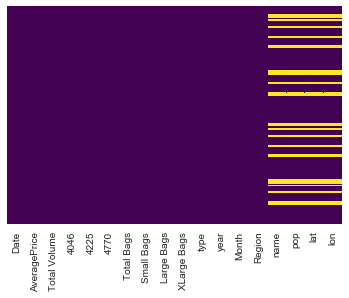

In [55]:
#Now let's check if there is null values in the new dataframes or not.
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

    Some regions can not find its geographic informations in the df_USgeo dataframes. 
    Let's see which are they.

In [56]:
df[df['pop'].isnull()]['Region'].unique()

array(['BaltimoreWashington', 'Boise', 'BuffaloRochester',
       'CincinnatiDayton', 'DallasFtWorth', 'HarrisburgScranton',
       'HartfordSpringfield', 'MiamiFtLauderdale', 'Nashville',
       'NewOrleansMobile', 'PhoenixTucson', 'RaleighGreensboro',
       'RichmondNorfolk'], dtype=object)

In [57]:
#These regions that can not find a geographic information is a combination of two places. 
#I will keep them as they are.

In [58]:
#Let's have a usa geo info functions so we can easily check in the analysis later:
df_usaRegionGeoInfo = pd.read_csv(
    '../Captone/usaRegionGeoInfo.csv', 
    index_col=0
)

#df_usaRegionGeoInfo.head()
def usa_geo_info(RegionNameOrPartOfIt):
    return df_usaRegionGeoInfo[df_usaRegionGeoInfo['Region'].str.contains(RegionNameOrPartOfIt)]

usa_geo_info('Tam')

,name,pop,lat,lon,Region
52,Tampa,346934,27.947760,-82.458444,Tampa
503,Tamarac,61808,26.205212,-80.271055,Tamarac


In [59]:
#For example with more geographic information, we can make a map plot.
group_dfByRegionYear = df.groupby(['Region','year'],as_index=False).mean()
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,Month,Region,name,pop,lat,lon
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,1,Albany,Albany,98012.0,42.651167,-73.754968
1,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,1,Albany,Albany,77746.0,42.651167,-73.754968
2,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,1,Albany,Albany,51053.0,42.651167,-73.754968
3,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,1,Albany,Albany,18767.0,42.651167,-73.754968
4,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,1,Albany,Albany,98012.0,42.651167,-73.754968


In [60]:
#In order to see the difference and change of the AveragePrice better
#Let's normalize them.
from sklearn import preprocessing

x = group_dfByRegionYear['AveragePrice'].values.reshape(-1, 1) #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
group_dfByRegionYear['NormalizedAveragePrice']= pd.DataFrame(x_scaled)

group_dfByRegionYear.head()


,Region,year,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,Month,pop,lat,lon,NormalizedAveragePrice
0,Albany,2015,1.538750,38749.004135,534.970096,30959.871154,334.397500,6919.765385,6744.927404,173.515865,1.322115,6.519231,61394.5,42.651167,-73.754968,0.532391
1,Albany,2016,1.533942,50618.611442,2717.872308,39807.862788,32.300288,8060.576058,7629.006154,222.989038,208.590769,6.442308,61394.5,42.651167,-73.754968,0.527710
2,Albany,2017,1.681154,62645.942404,9789.212500,39132.731731,157.232404,13566.765769,8509.092981,4875.495962,182.186442,6.423077,61394.5,42.651167,-73.754968,0.671035
3,Albany,2018,1.449592,64017.272245,5076.326735,47879.757143,49.180000,11012.008367,8517.798265,2337.869694,156.340408,6.061224,61394.5,42.651167,-73.754968,0.445587
4,Albany,2019,1.430938,63269.676667,2334.495417,51967.569271,140.252500,8827.328229,5703.501979,2849.039479,274.807604,6.125000,61394.5,42.651167,-73.754968,0.427425


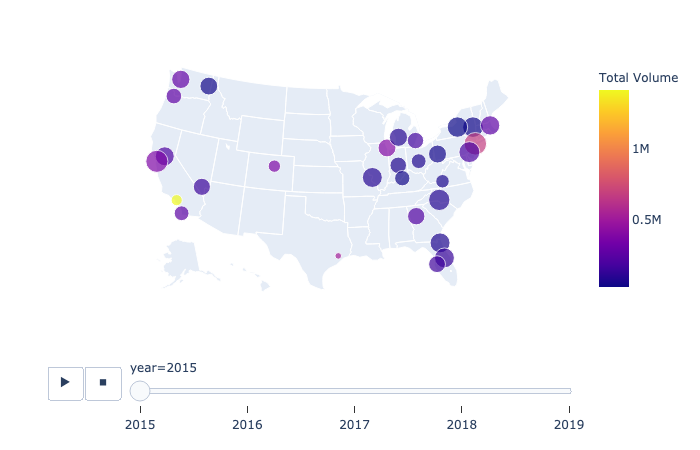

In [68]:
import plotly.graph_objects as go
import plotly.express as px

desiredMaximumMarkerSize =3

sizeref = 2. * max(group_dfByRegionYear['NormalizedAveragePrice']) / (desiredMaximumMarkerSize ** 2)



fig = px.scatter_geo(group_dfByRegionYear, 
                     #locationmode = 'USA-states',
                     lon = 'lon',
                     lat = 'lat', 
                     color="Total Volume",
                     hover_name="Region", 
                     size="NormalizedAveragePrice",
                     animation_frame = "year",
                     projection = "albers usa",
                     scope="usa"
                    )



# fig.show()
fig.show("png")

    By just looking at the change of the pattern size, it seems like that there is a peak in 2017.

### Column_Types

Explore the price and volume of the conventional and organic avocado.

In [62]:
conventional = df[df.type =='conventional']
conventional_groupByDate = conventional.groupby('Date').mean()
organic = df[df.type =='organic'].groupby('Date').mean()
organic_groupByDate = organic.groupby('Date').mean()
organic_groupByDate.head()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year,Month,pop,lat,lon
Date,,,,,,,,,,,,,,
2015-01-04,1.606094,8157.813437,3544.819375,2993.934687,59.194375,1559.865000,968.250313,591.614687,0.0,2015,1,612212.196078,38.546966,-90.940838
2015-01-11,1.662031,9322.885781,3985.912500,3913.128438,51.988125,1371.856719,928.268125,443.588594,0.0,2015,1,612212.196078,38.546966,-90.940838
2015-01-18,1.694531,9902.903594,3291.175781,4840.920469,53.794844,1717.012500,825.704375,891.308125,0.0,2015,1,612212.196078,38.546966,-90.940838
2015-01-25,1.712031,7305.642812,3005.396563,2880.801875,64.042031,1355.402344,797.074375,558.327969,0.0,2015,1,612212.196078,38.546966,-90.940838
2015-02-01,1.578750,9862.181719,4258.845469,3526.075781,82.937656,1994.322813,1243.945938,750.376875,0.0,2015,2,612212.196078,38.546966,-90.940838


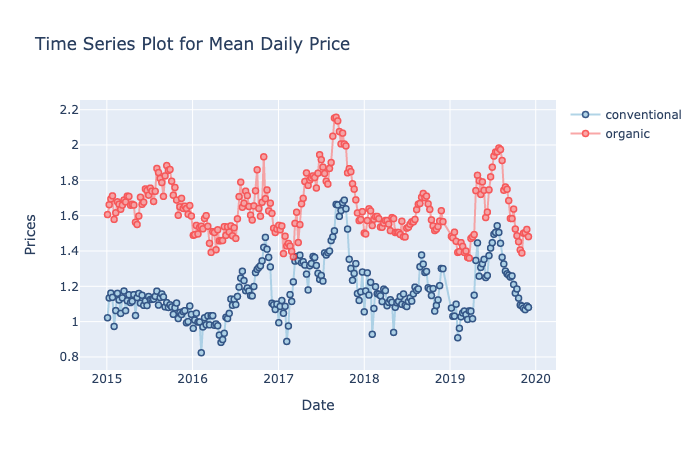

In [67]:
#Plot the time series of organic and conventional avocado price
import plotly
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)



fig = go.Figure()



scatter1=go.Scatter(x=conventional_groupByDate.index,y=conventional_groupByDate.AveragePrice,
                   name='conventional',mode='lines+markers',marker=dict(
                                 color='rgb(158,202,225)',
                                 line=dict(
                                 color='rgb(8,48,107)',
                                 width=1.5)),
                                opacity=0.8)
scatter2=go.Scatter(x=
organic_groupByDate.index,y=organic_groupByDate.AveragePrice,
                   name='organic',mode='lines+markers',marker=dict(
                                 color='rgb(248,146,146)',
                                 line=dict(
                                 color='rgb(249,52,52)',
                                 width=1.5)),
                                opacity=0.8)

data=[scatter1,scatter2]

layout = go.Layout(title='Time Series Plot for Mean Daily Price',
                  xaxis={'title':'Date'},yaxis={'title':'Prices'})
fig=go.Figure(data=data,layout=layout)
# iplot(fig)
fig.show("png")


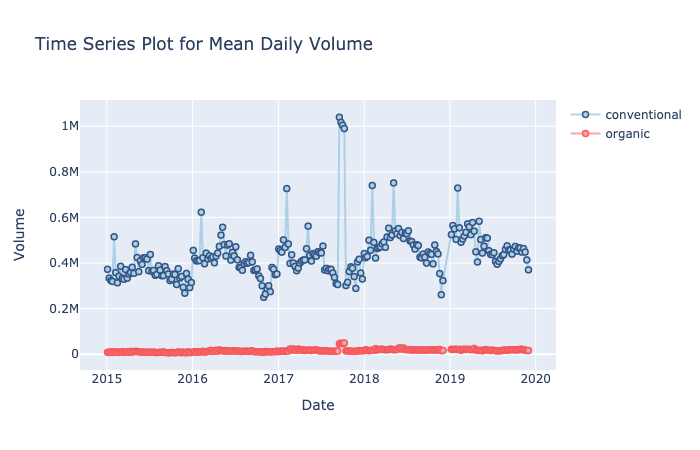

In [65]:
#Plot the time series of organic and conventional avocado Total Volumn
import plotly
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

fig = go.Figure()

scatter1=go.Scatter(x=conventional_groupByDate.index,y=conventional_groupByDate['Total Volume'],
                   name='conventional',mode='lines+markers',marker=dict(
                                 color='rgb(158,202,225)',
                                 line=dict(
                                 color='rgb(8,48,107)',
                                 width=1.5)),
                                opacity=0.8)
scatter2=go.Scatter(x=organic_groupByDate.index,y=organic_groupByDate['Total Volume'],
                   name='organic',mode='lines+markers',marker=dict(
                                 color='rgb(248,146,146)',
                                 line=dict(
                                 color='rgb(249,52,52)',
                                 width=1.5)),
                                opacity=0.8)

data=[scatter1,scatter2]

layout = go.Layout(title='Time Series Plot for Mean Daily Volume',
                  xaxis={'title':'Date'},yaxis={'title':'Volume'})
fig=go.Figure(data=data,layout=layout)
# iplot(fig)


fig.show("png")



 The conventional avocado volume is more than 10 times higher than that of organic one. 
 We want to focus on predicting the price of the conventional avocado. 

# Export data

In [35]:
#Above are the general data cleansing and feature creation. Let's save the dataframe

df.to_csv('/Users/liujing/Desktop/Coursera/Captone/AfterCleansingFeatureCreation_AvocadoPriceUSA20152019.csv')
conventional.to_csv('/Users/liujing/Desktop/Coursera/Captone/conventional.csv')
organic.to_csv('/Users/liujing/Desktop/Coursera/Captone/organic.csv')



In [129]:
df = pd.read_csv('../Captone/AfterCleansingFeatureCreation_AvocadoPriceUSA20152019.csv',index_col=0)
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,Month,Region,name,pop,lat,lon
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1,Albany,Albany,98012.0,42.651167,-73.754968
1,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1,Albany,Albany,77746.0,42.651167,-73.754968
2,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1,Albany,Albany,51053.0,42.651167,-73.754968
3,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1,Albany,Albany,18767.0,42.651167,-73.754968
4,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1,Albany,Albany,98012.0,42.651167,-73.754968


In [130]:
df.columns

Index(['Date', 'AveragePrice', 'Total Volume', '4046', '4225', '4770',
       'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year',
       'region', 'Month', 'Region', 'name', 'pop', 'lat', 'lon'],
      dtype='object')